In [2]:
import pandas as pd
import boto3
import os
from pathlib import Path

In [2]:
# Downloading data from s3 bucket.
# from pathlib import Path
# ECG_DATA_BUCKET = "ritesh-s3-ecg-annotated-data"
# s3 = boto3.client("s3")
# for fl in lst_images:
#     fn = Path(fl).name
#     print(fn
#     s3.download_file(ECG_DATA_BUCKET,fn,f'./ecg-annotated-data/{fn}')

In [21]:
new_file_name = 'annotation-info.csv'
df_labels = pd.read_csv(new_file_name); df_labels.head()
# Label cleansing required a bit
df_labels['choice'].value_counts()

Normal                                                                     188
Others                                                                      94
Myocardial Infarction                                                       21
Left Ventricular Hypertropy                                                 13
Left Atrial Enlargement                                                      9
Ischemia                                                                     8
{"choices": ["Ischemia", "Others"]}                                          5
Right Bundle Branch Block                                                    4
{"choices": ["Ischemia", "Left Ventricular Hypertropy"]}                     4
{"choices": ["Myocardial Infarction", "Others"]}                             3
{"choices": ["Ischemia", "Left Atrial Enlargement"]}                         2
{"choices": ["Myocardial Infarction", "Left Ventricular Hypertropy"]}        2
{"choices": ["Left Atrial Enlargement", "Others"]}  

In [24]:
def cleanse_labels(str_labels):
    try:
        str_labels = str_labels.replace('"choices":', "").replace('{ ["','').replace('"]}','').replace('"', '').replace(", ", ";")
    except:
        pass
    return(str_labels)
df_labels['labels'] = list(map(cleanse_labels, df_labels['choice']))
df_labels['labels'].value_counts()

Normal                                                 188
Others                                                  94
Myocardial Infarction                                   21
Left Ventricular Hypertropy                             13
Left Atrial Enlargement                                  9
Ischemia                                                 8
Ischemia;Others                                          5
Right Bundle Branch Block                                4
Ischemia;Left Ventricular Hypertropy                     4
Myocardial Infarction;Others                             3
Myocardial Infarction;Left Ventricular Hypertropy        2
Ischemia;Left Atrial Enlargement                         2
Right Atrial Enlargement                                 1
Left Bundle Branch Block                                 1
Left Atrial Enlargement;Others                           1
Left Ventricular Hypertropy;Left Atrial Enlargement      1
Myocardial Infarction;Right Ventricular Hypertropy      

In [25]:
# Considering Normal Others and Myocardial Infarction.
df_training_labels =  df_labels[df_labels['labels'].isin(['Normal','Others','Myocardial Infarction'])].reset_index()
df_training_labels['labels'].value_counts()

Normal                   188
Others                    94
Myocardial Infarction     21
Name: labels, dtype: int64

In [3]:
! pip install fastai==2.3.1 > /dev/null

In [4]:
! pip install pillow==8.2 

In [5]:
import fastai
from fastai.vision.all import *

In [29]:
def get_name_of_file(x):
    return(Path(x).name)
df_training_labels['image_name'] = list(map(get_name_of_file, df_training_labels['image']))
df_train = df_training_labels[['image_name', 'labels']]
df_train

,image_name,labels
0,20201103-090540-1035.pdf.jpg,Normal
1,20201014-075943-977.pdf.jpg,Others
2,20201104-114447-1041.pdf.jpg,Others
3,20201201-124218-1205.pdf.jpg,Others
4,20210128-134038-66.pdf.jpg,Normal
...,...,...
298,20201029-090143-1022.pdf.jpg,Others
299,20200911-100026-874.pdf.jpg,Normal
300,20201021-073749-1000.pdf.jpg,Normal
301,20200930-165410-935.pdf.jpg,Myocardial Infarction


In [18]:
# def get_training_files(path = './ecg-annotated-data'):
#     fnames = get_image_files(path)
#     training_files = []
#     for f in fnames:
#         df_res =  df_training_labels[df_training_labels['image_name'] ==  Path(f).name]
#         if df_res.shape[0] == 1:
#             training_files.append(f)
#     return(training_files)
# ft = get_training_files()
# len(ft)

In [22]:
# DO NOT DELETE
# Extra step to copy all files which are part of data frame only, this should solve the problem.
# NEW_IMAGE_DIR = './ecg-subset-annotated-data/'
# os.makedirs(NEW_IMAGE_DIR)
# import shutil
# for fl in df_train['image_name']:
#     src_file = IMAGE_DIR + fl
#     targ_file = NEW_IMAGE_DIR + fl
#     try:
#         shutil.copyfile(src_file, targ_file)
#     except:
#         pass
# print("done")

In [30]:
IMAGE_DIR = '../ecg-annotated-data/'
# Need to remove those files which are in the dataset but not on the disk.
avlfiles = []
for fl in df_train['image_name']:
    if os.path.exists(IMAGE_DIR+ fl):
        avlfiles.append(fl)
df_avl = pd.DataFrame({'image_name':avlfiles}) ; df_avl.head()
df_train_final = pd.merge(df_train,df_avl,on='image_name')
df_train_final.head()

,image_name,labels
0,20201103-090540-1035.pdf.jpg,Normal
1,20201014-075943-977.pdf.jpg,Others
2,20201104-114447-1041.pdf.jpg,Others
3,20201201-124218-1205.pdf.jpg,Others
4,20210128-134038-66.pdf.jpg,Normal


In [24]:
# This is important as using a label_func causes the lambda function to look for it and 
# it does not find this. Using ImageDataLoaders.from_df is safe.
dls = ImageDataLoaders.from_df(df_train_final
                               , IMAGE_DIR
                               , label_col = 'labels'
                               , item_tfms = RandomResizedCrop(128, min_scale=0.35)
                               , bs = 32)

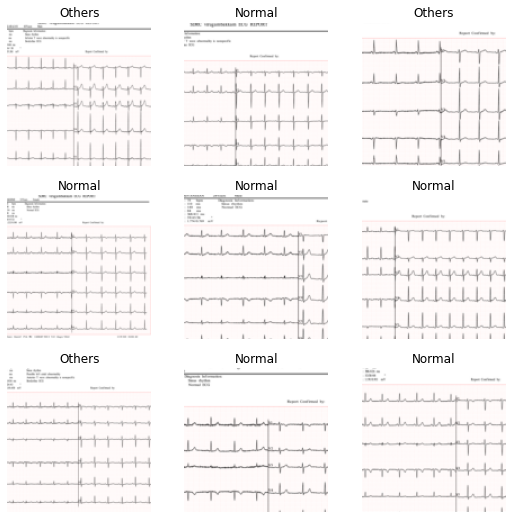

In [25]:
dls.show_batch()

In [26]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [27]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.928979,1.685200,0.810345,02:36
1,1.865341,1.987263,0.879310,02:25
2,1.815528,1.649547,0.706897,02:25
3,1.799948,1.742653,0.706897,02:26
4,1.769533,1.991374,0.758621,02:27
5,1.738373,1.663711,0.603448,02:27
6,1.706868,1.500805,0.551724,02:24
7,1.674759,1.514418,0.586207,02:27
8,1.633083,1.553848,0.448276,02:26
9,1.599384,1.186626,0.413793,02:25


In [28]:
learn.export('/home/ec2-user/SageMaker/model-dec14-30-epochs.pkl')

In [29]:
print("Done upto here.")

Done upto here.


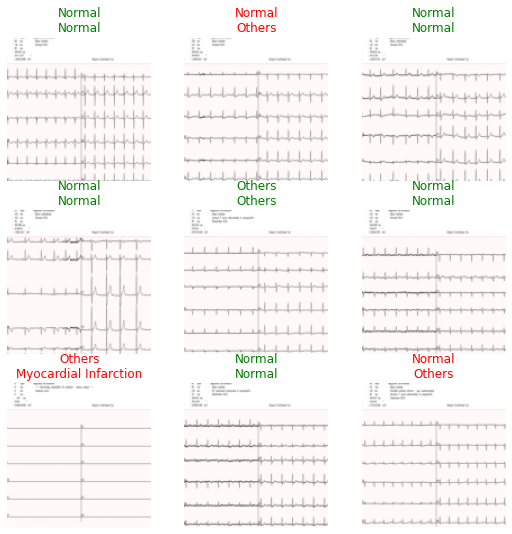

In [30]:
learn.show_results()

In [ ]:
# Carry on from here if this succeeds.

In [31]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.181726,0.926051,0.344828,02:27
1,1.043244,0.883620,0.344828,02:25
2,1.040251,0.844494,0.310345,02:25
3,1.027115,0.830728,0.310345,02:25
4,1.037989,0.834793,0.293103,02:29
5,1.013950,0.840477,0.293103,02:26
6,1.006109,0.872874,0.275862,02:25
7,0.984978,0.942275,0.293103,02:27
8,0.978265,0.917428,0.344828,02:23
9,0.947185,0.875352,0.344828,02:26


In [ ]:
learn.export('/home/ec2-user/SageMaker/model2-14dec21-60-epochs.pkl')

In [ ]:
# Testing

In [7]:
mdl = load_learner("../model-dec14-30-epochs-error-rate-36.pkl")

In [8]:
mdl

In [9]:
# test_local_files = Path('../ecg-annotated-data/').ls()

In [31]:
def get_test_prediction(fl):
  d = {}
  try:
      out = mdl.predict(fl)
      d['image_name'] = fl.name
      d['predict_label'] = out[0]
      d['predict_prob'] = out[2].numpy().max()
  except:
    pass
  return( d )
test_predicted = list(map(get_test_prediction, test_local_files))
df_res = pd.DataFrame(test_predicted)
df_res.head()

In [34]:
df_consolidated_results = pd.merge(df_training_labels, df_res, on = ["image_name"])[['image_name', 'choice', 'predict_label']]
df_consolidated_results = df_consolidated_results.rename(columns =  {"choice": "actual_label", "image_name": "file"})
df_consolidated_results

,file,actual_label,predict_label
0,20201103-090540-1035.pdf.jpg,Normal,Others
1,20201014-075943-977.pdf.jpg,Others,Others
2,20201104-114447-1041.pdf.jpg,Others,Normal
3,20201201-124218-1205.pdf.jpg,Others,Others
4,20210128-134038-66.pdf.jpg,Normal,Normal
...,...,...,...
285,20201029-090143-1022.pdf.jpg,Others,Others
286,20200911-100026-874.pdf.jpg,Normal,Normal
287,20201021-073749-1000.pdf.jpg,Normal,Normal
288,20200930-165410-935.pdf.jpg,Myocardial Infarction,Normal


In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

                       precision    recall  f1-score   support

Myocardial Infarction       0.36      0.25      0.29        20
               Normal       0.82      0.74      0.78       181
               Others       0.52      0.65      0.58        89

             accuracy                           0.68       290
            macro avg       0.56      0.55      0.55       290
         weighted avg       0.69      0.68      0.68       290



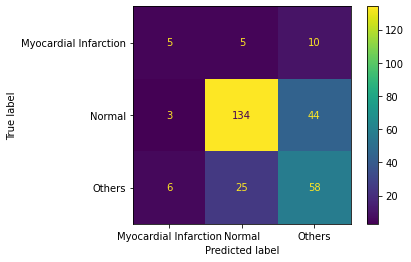

In [36]:
matrix = confusion_matrix(df_consolidated_results['actual_label'],df_consolidated_results['predict_label'])
cr = classification_report(y_true = df_consolidated_results['actual_label']
                      ,y_pred = df_consolidated_results['predict_label'])

print(cr)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=mdl.dls.vocab)
disp.plot() 

In [38]:
df_training_labels['choice'].value_counts()

Normal                   188
Others                    94
Myocardial Infarction     21
Name: choice, dtype: int64